In [1]:
from keras.applications.vgg16 import VGG16
from keras.applications.xception import Xception
from keras.applications.inception_v3 import InceptionV3
from keras.utils import img_to_array
from sklearn.preprocessing import LabelEncoder
from keras.models import Model

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from imutils import paths
import cv2
import random
import os
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import seaborn as sns
import pandas as pd

In [2]:
img_width, img_height = 224, 224
path = './data'
norm_size = 224
class_num = 2

In [3]:
def load_data(path, norm_size):
    data = []
    label = []
    for split in ['train', 'test']:
        split_path = os.path.join(path, split)
        for class_folder in os.listdir(split_path):
            class_path = os.path.join(split_path, class_folder)
            image_paths = sorted(list(paths.list_images(class_path)))
            random.seed(0)
            for each_path in image_paths:
                image = cv2.imread(each_path)
                image = cv2.resize(image, (norm_size, norm_size))
                image = img_to_array(image)
                data.append(image)
                maker = class_folder
                label.append(maker)
    data = np.array(data, dtype="float") / 255.0
    label = np.array(label)
    return data, label

In [4]:
data, label = load_data(path, norm_size)

In [5]:
model = InceptionV3(weights='imagenet', include_top=False)
model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, None, None, 3)]      0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, None, None, 32)       864       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, None, None, 32)       96        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, None, None, 32)       0         ['batch_normalizati

In [6]:
layer_outputs = [layer.output for layer in model.layers[:120]] 
activation_model = Model(inputs=model.input, outputs=layer_outputs)
activations = activation_model.predict(data)

4/4 [==============================] - 2s 420ms/step


In [7]:
selected_layer = 50
feature_map = np.reshape(activations[selected_layer], (activations[selected_layer].shape[0], -1))
print(f"Forma del mapa de características: {feature_map.shape}")

Forma del mapa de características: (108, 160000)


In [8]:
random.seed(0)
feature_map, label = zip(*random.sample(list(zip(feature_map, label)), len(label)))
X_train, X_test, y_train, y_test = train_test_split(feature_map, label, test_size=0.3, random_state=42)
len(X_train), len(X_test)

(75, 33)

In [9]:
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)

In [10]:
classifiers = {
    'RandomForest': RandomForestClassifier(),
    'SVM': SVC()
}

In [11]:
param_grid_rf = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10]
}

In [12]:
param_grid_svm = {
    'C': [0.1, 1, 10],
    'gamma': [1, 0.1, 0.01],
    'kernel': ['rbf', 'poly', 'sigmoid']
}

In [13]:
best_estimators = {}
for name, clf in classifiers.items():
    if name == 'RandomForest':
        grid = GridSearchCV(clf, param_grid_rf, cv=3, scoring='accuracy')
    elif name == 'SVM':
        grid = GridSearchCV(clf, param_grid_svm, cv=3, scoring='accuracy')
    
    grid.fit(X_train, y_train_enc)
    best_estimators[name] = grid.best_estimator_
    print(f"Mejores parámetros para {name}: {grid.best_params_}")

Mejores parámetros para RandomForest: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 100}
Mejores parámetros para SVM: {'C': 0.1, 'gamma': 1, 'kernel': 'poly'}


Evaluando RandomForest...
Matriz de confusión para RandomForest:


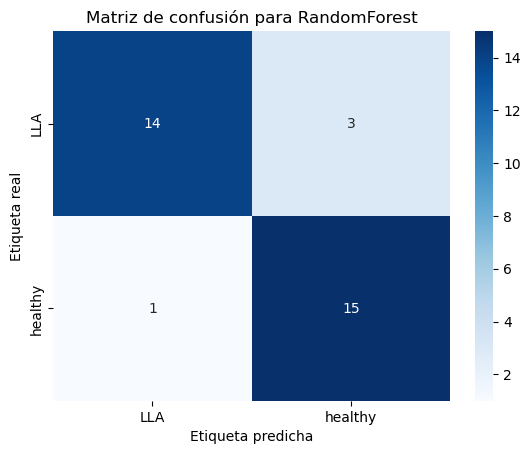

Informe de clasificación para RandomForest:
              precision    recall  f1-score   support

         LLA       0.93      0.82      0.87        17
     healthy       0.83      0.94      0.88        16

    accuracy                           0.88        33
   macro avg       0.88      0.88      0.88        33
weighted avg       0.88      0.88      0.88        33

Accuracy para RandomForest: 0.8788
Evaluando SVM...
Matriz de confusión para SVM:


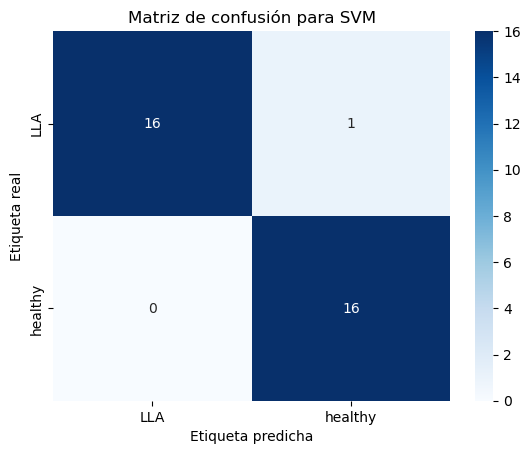

Informe de clasificación para SVM:
              precision    recall  f1-score   support

         LLA       1.00      0.94      0.97        17
     healthy       0.94      1.00      0.97        16

    accuracy                           0.97        33
   macro avg       0.97      0.97      0.97        33
weighted avg       0.97      0.97      0.97        33

Accuracy para SVM: 0.9697


In [14]:
for name, clf in best_estimators.items():
    print(f"Evaluando {name}...")
    predictions = clf.predict(X_test)
    print(f"Matriz de confusión para {name}:")
    cm = confusion_matrix(y_test_enc, predictions)
    df_cm = pd.DataFrame(cm, index=le.classes_, columns=le.classes_)
    sns.heatmap(df_cm, annot=True, cmap='Blues')
    plt.title(f'Matriz de confusión para {name}')
    plt.ylabel('Etiqueta real')
    plt.xlabel('Etiqueta predicha')
    plt.show()
    
    print(f"Informe de clasificación para {name}:")
    print(classification_report(y_test_enc, predictions, target_names=le.classes_))

    accuracy = accuracy_score(y_test_enc, predictions)
    print(f"Accuracy para {name}: {round(accuracy, 4)}")